<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Подготовка-к-работе" data-toc-modified-id="Подготовка-к-работе-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к работе</a></span></li><li><span><a href="#A/B-test" data-toc-modified-id="A/B-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A/B test</a></span></li><li><span><a href="#Пуассоновский-бутстреп-для-подсчета-разницы-в-CTR" data-toc-modified-id="Пуассоновский-бутстреп-для-подсчета-разницы-в-CTR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Пуассоновский бутстреп для подсчета разницы в CTR</a></span></li><li><span><a href="#T-тест-на-сглаженном-CTR" data-toc-modified-id="T-тест-на-сглаженном-CTR-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>T-тест на сглаженном CTR</a></span></li><li><span><a href="#T-test-и-тест-Манна-Уитни-поверх-бакетноего-преобразования" data-toc-modified-id="T-test-и-тест-Манна-Уитни-поверх-бакетноего-преобразования-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>T-test и тест Манна-Уитни поверх бакетноего преобразования</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Описание этапов анализа проведенного эксперемента по увеличению CTR 

## Описание задачи

Цель: понять, можно ли раскатывать новый алгоритм рекомендаций для пользователей приложения на всех пользователей

Что дано: 
- некоторая социальная сеть и нам доступны данные о действиях ее пользовтелей  
- разработан новый алгоритм рекомендаций для пользователей приложения, который увеличит количество лайков, чем привлечет больший интерес к продукту
- дата проведения эксперемента: с 31.01.2025 по 06.02.2025 гг.
- новый алгоритм был применен к пользователям второй эксперементальной группы

План действий:  
В силу того, что тестирование группы уже прошло и можно проводить A/B тест по результатам эксперемента, хочется еще раз убедиться в статистической эквивалентности выбранных групп и провести A/A тест.  
A/A тест проведем на эксперементальных группах 2 и 1, данные для исследования возьмем с 24.01.2025 по 30.01.2025 гг.

<div style="background-color: #FFCCCB; padding: 10px;">
    ⚠️ Внимание!<br>
    Весь код проекта, в этой тетрадке представлен не будет, показыны будут осноные моменты и описаны выводы.
</div>


## Подготовка к работе

- Выгружаются необходимые библиотеки 
- Выгружаются данные в датафрейм  
- Проверяется распределение пользоваелей по группам
- Рассчитываются основные метрики (кол-во уникальных пользователей, лайков, просмотров, ctr)



<div style="background-color: #D8A7D6; padding: 10px;">
    Пример библиотек и датафрейма.
</div>


In [2]:
#библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import FileLink
from IPython.display import HTML
import swifter
import hashlib
from scipy import stats
import numpy as np

#датафрейм

# выгрузим данные января 
df1=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\feed_actions1.csv')
# выгрузим данные февраля 
df2=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\feed_actions2.csv')

#объеденим данные
df= pd.concat([df1, df2], ignore_index=True)
df.head()


,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group,rn
0,106791,76,view,2025-01-04 00:26:19,0,45,Russia,Chelyabinsk,iOS,ads,3,1
1,659,76,view,2025-01-04 00:26:31,0,30,Russia,Partizansk,Android,ads,0,2
2,106791,76,like,2025-01-04 00:27:59,0,45,Russia,Chelyabinsk,iOS,ads,3,3
3,695,76,view,2025-01-04 00:29:39,1,27,Russia,Engels,Android,ads,0,4
4,695,76,like,2025-01-04 00:29:51,1,27,Russia,Engels,Android,ads,0,5


<div style="background-color: #D8A7D6; padding: 10px;">
    Проверка корректности сплитования пользователей на эксперементальные группы.
</div>

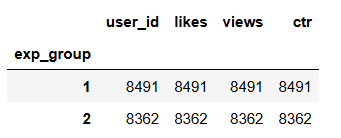



<div style="background-color: #e6e6fa; padding: 10px;">
    Пользователи распределены в эксперементальных группах относительно равномерно, больших перекосов не замечено.<br>   
    Делаем вывод, что мы можем продолжать анализ и работу с 1 и 2 группой.<br> 
    Построим график распределения наших групп.
</div>

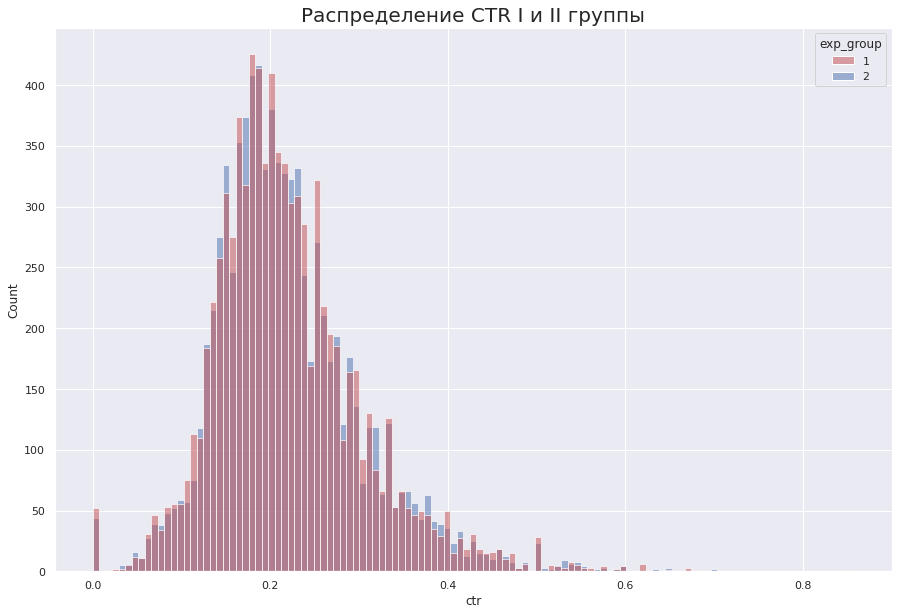

<div style="background-color: #e6e6fa; padding: 10px;">
    По результатам визуализации делаем вывод:<br>  
    Значимых выбросов нет, группы распределены корректно. <br> 
    <b>Проведем оценку группы 1 и 2 через t-test</b>
</div>

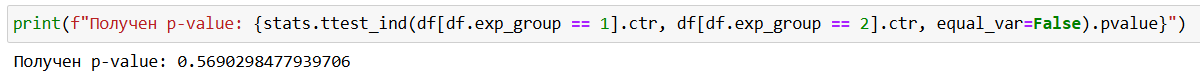

<div style="background-color: #e6e6fa; padding: 10px;">
    Данные имеют высокий p-value, что позволяет предположить о схожести выборок.<br> 
    Приступим к проведению A/B тестирования.<br> 
    <br>
    exp_group = 1 - Наша контрольная группа, где никаких изменений не было<br>
    exp_group = 2 - Группа, в которой произошли изменнения в алгоритме рекомендации "похожих на лайкнутые постов"
</div>

## A/B test

- Выгружаются данные в датафрейм за период эксперемента
- Рассчитываются основные метрики (кол-во уникальных пользователей, лайков, просмотров, ctr)
- Проверка t-test 
- Визуализация распределения ctr контрольной и тестовой группы

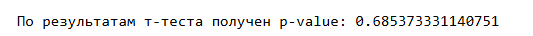

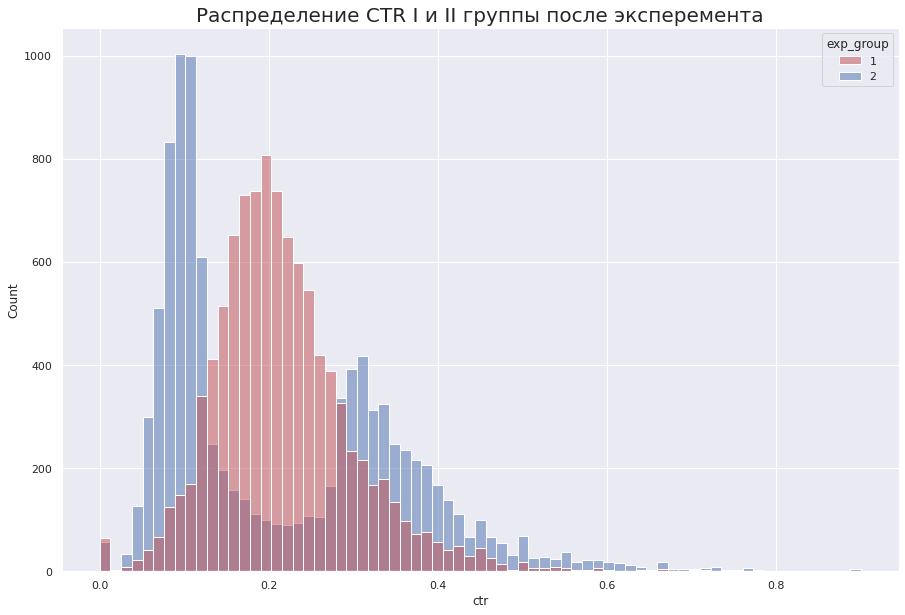


<div style="background-color: #e6e6fa; padding: 10px;">
    Результат т-теста не дал нам желаемоего результата, p-value оказался достаточно высок, чтобы показать различия, но на визуализации различия просматриваются. <br>  
    Проведем тест Манна-Уитни.
</div>

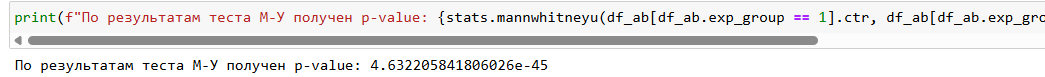

<div style="background-color: #e6e6fa; padding: 10px;">
    По результатам теста Манна-Уитни отличие прокрасилось. Делаем вывод, что результаты теста Манна-Уитни противоречат результатам проведеного ранее т-теста. <br>  
    
</div>    

<div style="background-color: #D8A7D6; padding: 10px;">
   Проверим вероятность того, что группа 2 превосходит группу 1 через построение бутстреп-выборок по каждой группе.
</div>

## Пуассоновский бутстреп для подсчета разницы в CTR  

- Описываем функцию, которая будет рассчитывать глобальный CTR для каждой эксперементальной группы
- Визуализируем распределение "сглаженных" CTR 
- Находим разницу между глобальными CTR и визуализируем ее для окончательного вывода 

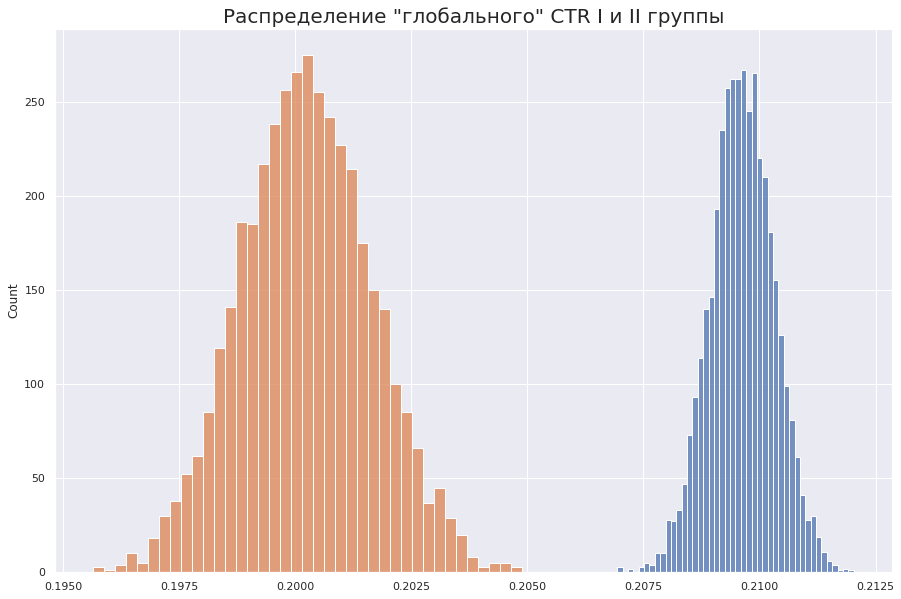

<div style="background-color: #e6e6fa; padding: 10px;">
   По результатам визуализации можно утверждать, что в одной из групп уровень значимости больше, чем в другой, но не намного.  
</div>    

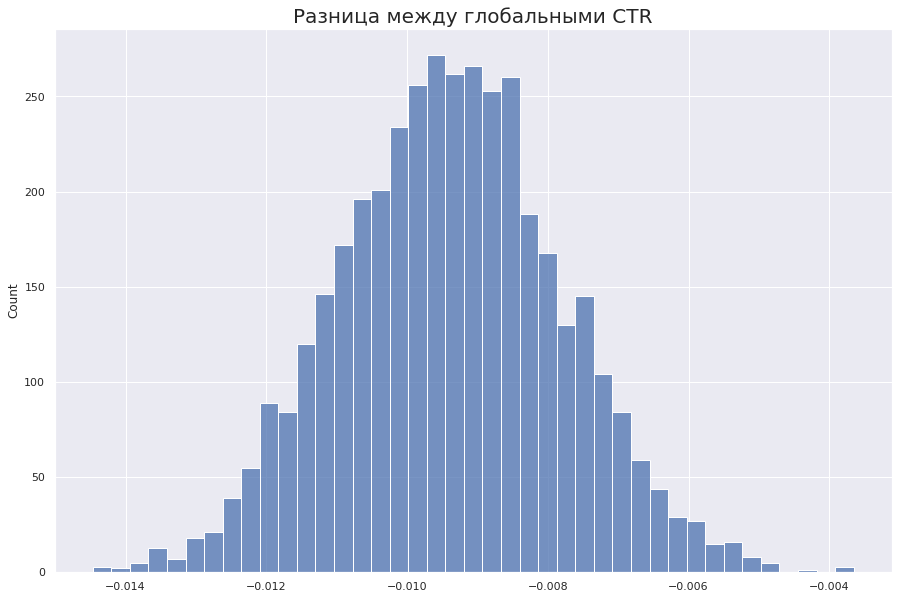

<div style="background-color: #e6e6fa; padding: 10px;">
   Разница между глобальными CTR не пересекает нулевое значений и отрицательна, можем сделать вывод, что <b>"глобальный CTR" второй группы, меньше, чем "глобальный CTR" первой группы</b>.<br> 
   Нулевое значение не пересекается, но очень близко к нему.<br>   
   
</div> 

<div style="background-color: #D8A7D6; padding: 10px;">
   Проведем t-тест на сглаженном ctr.  
</div>

##  T-тест на сглаженном CTR  

Для "сглаживания" нашего CTR напишем функцию и посмотрим на графики сглаженого глобального CTR

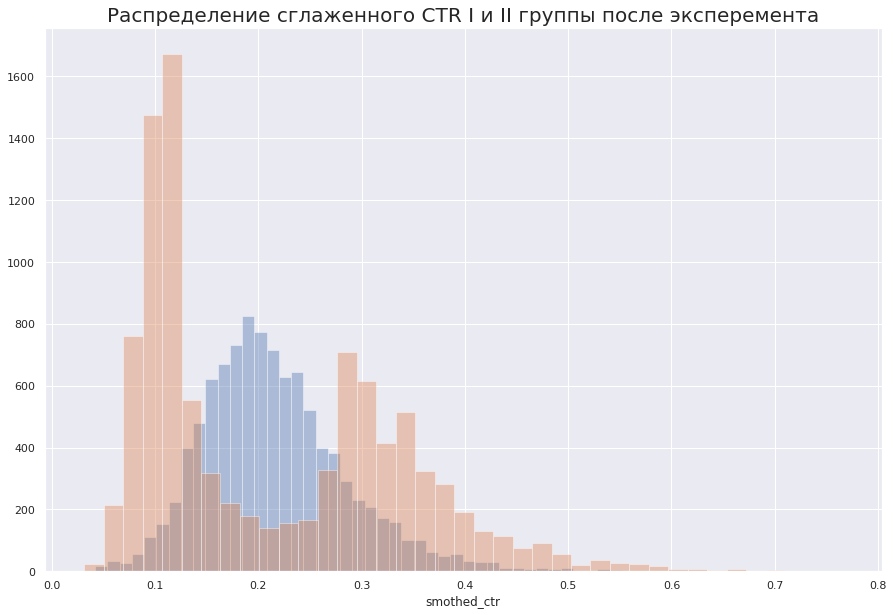

<div style="background-color: #e6e6fa; padding: 10px;">
   Распределение CTR второй группы (нашей таргет группы), не получилось "сгладить" до нормального распределения.<br>  
   В данной ситуации не совсем корректно проводить T-тест, но мы проведем в целях исследования.   
   
</div> 

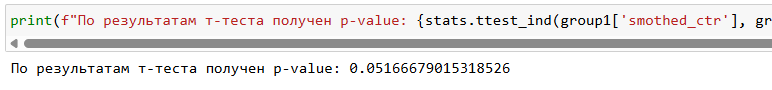

<div style="background-color: #e6e6fa; padding: 10px;">
   Результат t-теста практически равен выбранному нами уровню значимости 0,05. Тест не окрасился, но очень близок к этому.  
   
</div> 

## T-test и тест Манна-Уитни поверх бакетноего преобразования  

- Выгружаем датафрейм, но теперь добавляются бакеты
- Проводим тест Манна-Уитни
- В случае нормального распределения бакетных CTR проводим t-test

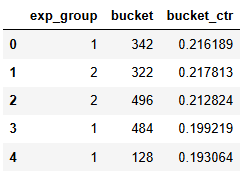

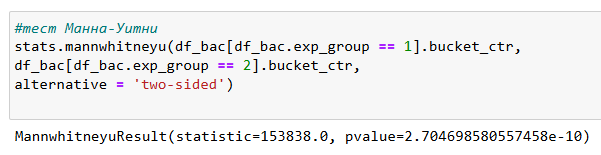

<div style="background-color: #e6e6fa; padding: 10px;">
   Тест Манна-Уитни видит отличие между нашими группами
</div> 

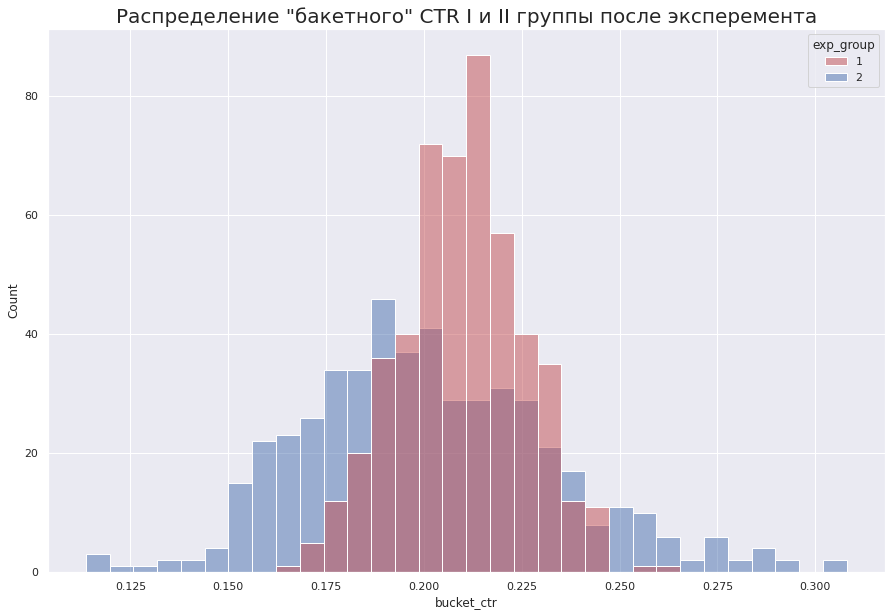

<div style="background-color: #e6e6fa; padding: 10px;">
   Распределение статистики внутри бакетов похоже на нормальное, в следствии этого вывода проведем т-тест.
</div> 

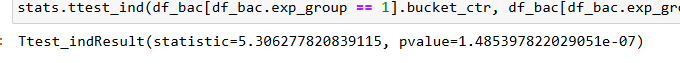

<div style="background-color: #e6e6fa; padding: 10px;">
    Статистический т-тест видит отличие между нашими группами. <br>
    По результатам проведенных тестов поверх бакетного преобразования, а также по результатам визуализации, можно предположить, что различие все-такие есть.
</div> 

## Выводы

**Почему результаты не однозначны?**  
Вторая эксперементальная группа, группа, к которой применялся новый алгоритм визуально, после эксперемента, имеет не нормальное распределение.  

Можно сделать предположение, что из-за этой "расщипленности", которую мы наблюдаем на графике распределения CTR второй группы, "мажутся" и противоречат друг другу результаты тестов.  

Обычный т-тест показал, что отличий нет и т-тест поверх сглаженного CTR показал, что отличий нет, но при этом p-value было очень близко к уровню значимости.  
T-тест поверх бакетноего преобразования окрасился. 
Тест Манна-Уитни окршивался всегда, p-value было значительно ниже уровня значимости во всех случаях.  

При анализе различий "глобальных CTR" по методу бутстрепа, можно счказать, что различия есть, но они минимальны.  


**По результатам проведенного анализа можно сказать, что новый алгоритм рекомендаций не принес ожидаемого результата.**  
- Отличие от контрольной группы есть, но оно идет в меньшую сторону, т.е. контрольная группа показала свой стабильный результат, а таргет группа показала "не стабильный", т.е. мы не можем сказать, что таргет группа явно лучше, но при этом не можем сказать, что она явно хуже.  
- Если смотреть в совокупности на харктер распределения групп после эксперемента, на числовые показатели, можно сказать, что алгоритм не принес увеличение CTR, более того, появились какие-то не характерные поведения пользователей. 
- Я бы не спешила расскатывать новый алгоритм на всех пользователей, возможно, стоит более детально изучить таргет группу, то как реагировали пользователи на новый алгоритм и доработать его.  
- В результате проведения теста было отмечено, что эксперементальная группа раделилась "на двое" и если у одной "подгруппы" пользователей ctr ниже нашей контрольной, то у другой "подгруппы" он явно больше.
Возможно стоит узнать хартер пользователей ctr, которых увеличился и понять, почему им "зашел" обновленный алгоритм.

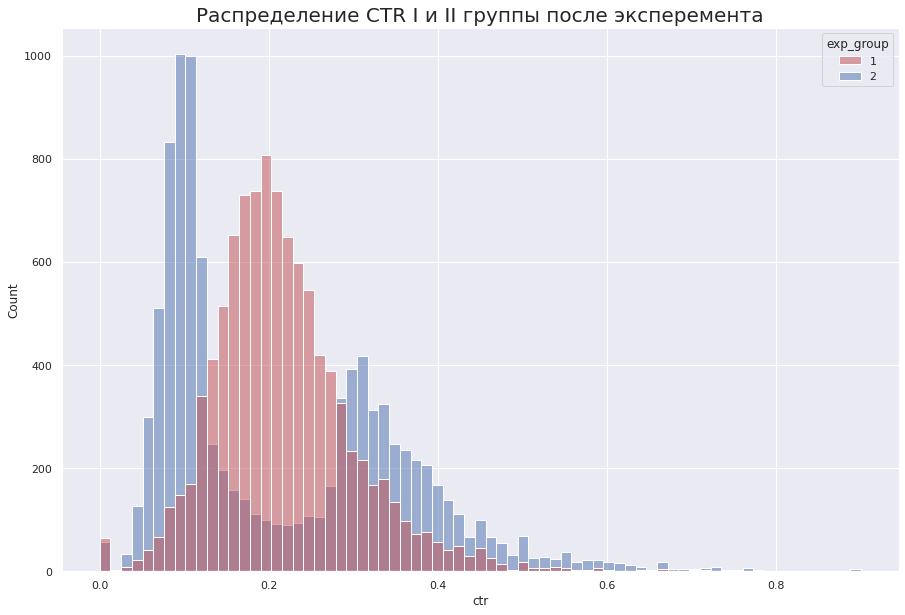